In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from puzzle_solver import plot
from puzzle_solver.tile_detector import detect_tiles
import scipy
from scipy.signal import find_peaks, find_peaks_cwt

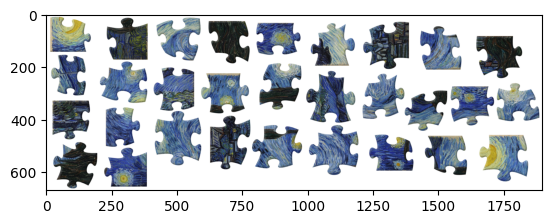

In [3]:
img = cv2.imread("../samples/van-gogh.png")
plot(img)

In [4]:
output = img.copy()

In [5]:
boxes, centroids, num_labels, labels = detect_tiles(img)

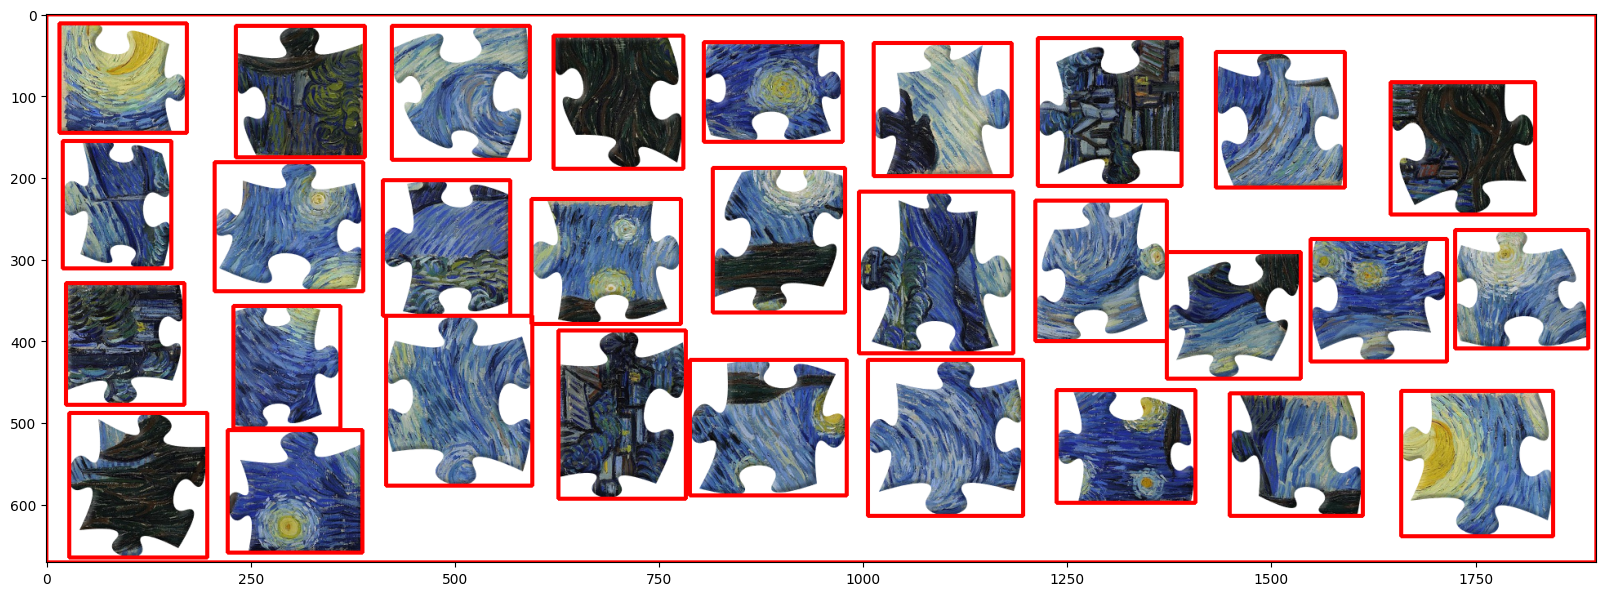

In [123]:
for box in boxes:
    cv2.rectangle(output, box[0], box[1], (0, 0, 255), 3)
plot(output, figsize=(20,10))

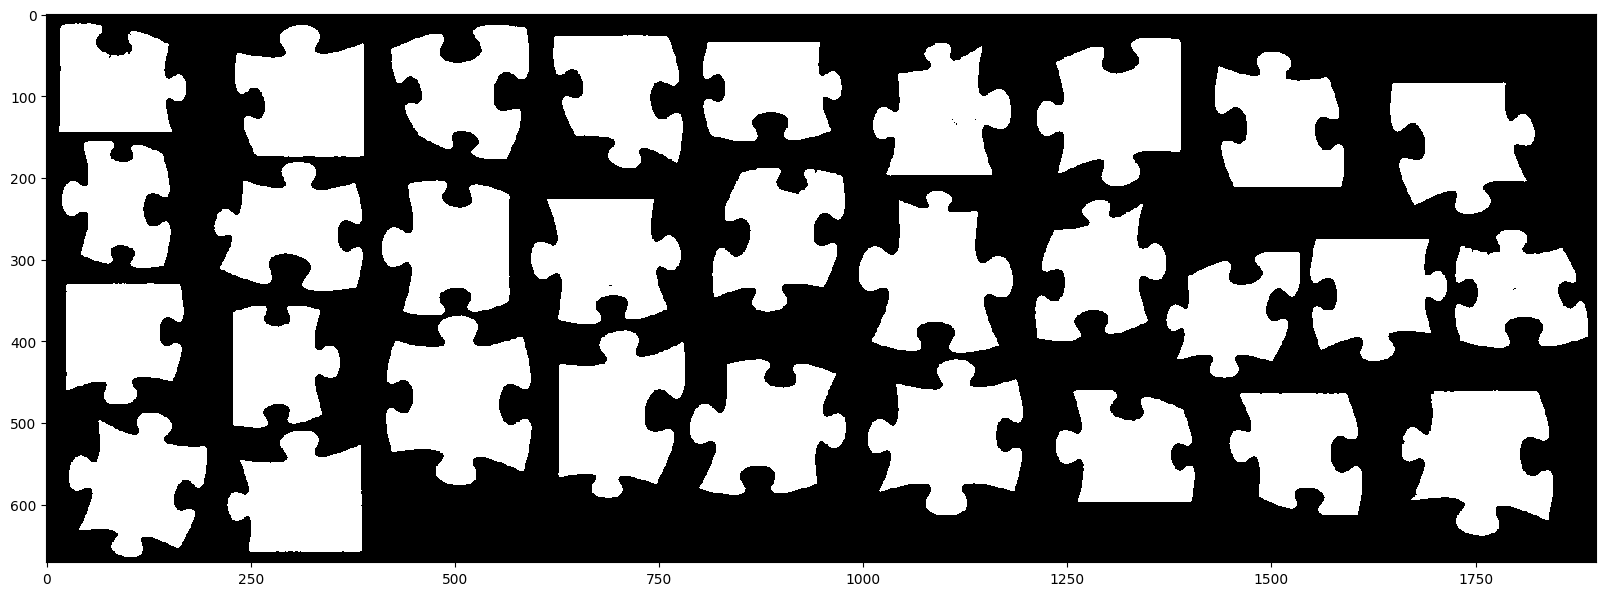

In [127]:
labels_image = np.uint8(labels>0)
plot(labels_image, figsize=(20,10))

number of puzzle pieces : 30


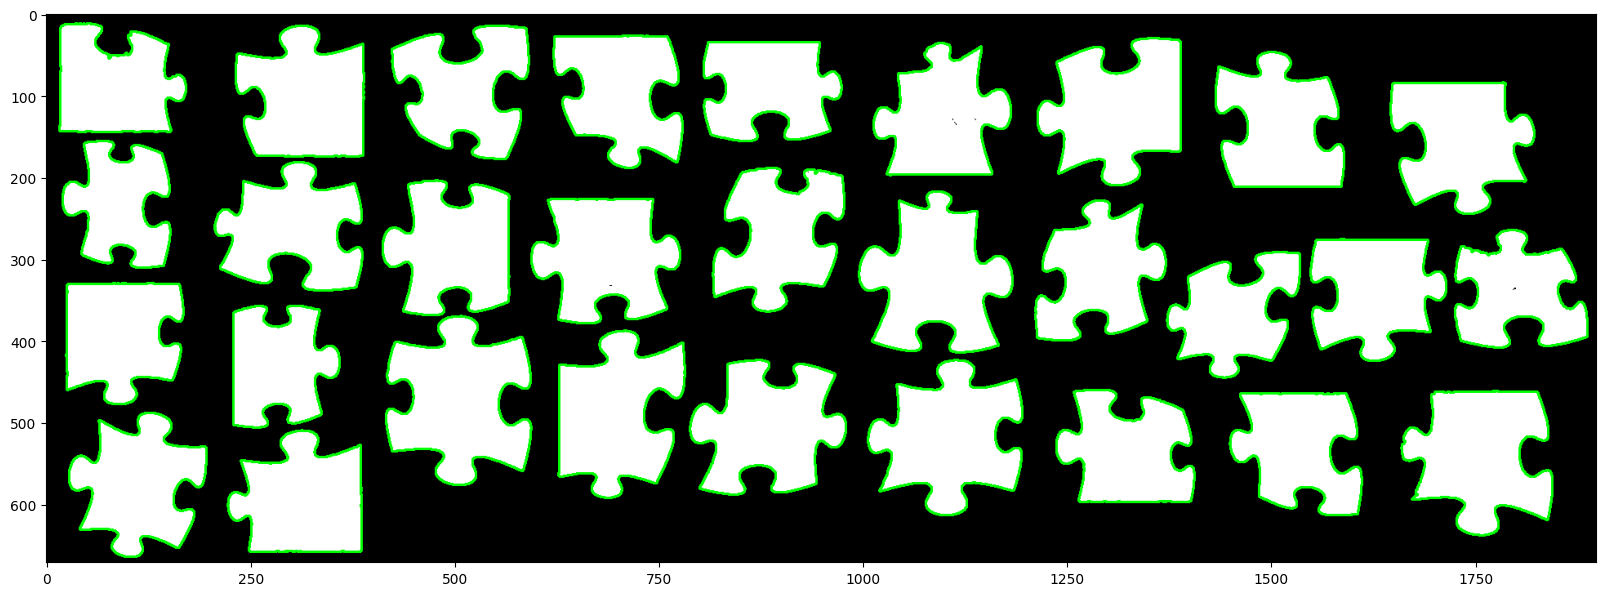

In [132]:
# Get contours
"""contours est une liste de liste où chaque liste correspond à un contour et chaque sous-liste est composée de deux éléments et correspond à un pixel"""
contours, hierarchy = cv2.findContours(labels_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print("number of puzzle pieces :", len(contours))

## Draw contours
labels_image_cop = cv2.cvtColor(labels_image.copy()*255, cv2.COLOR_GRAY2BGR)
cv2.drawContours(labels_image_cop, contours, -1, (0, 255, 0), 2)
plot(labels_image_cop, figsize=(20,10))

In [9]:
# Get the moments
mu = [None]*len(contours)
for i in range(len(contours)):
    mu[i] = cv2.moments(contours[i])
# Get the mass centers
mc = [None]*len(contours)
for i in range(len(contours)):
    # add 1e-5 to avoid division by zero
    mc[i] = (mu[i]['m10'] / (mu[i]['m00'] + 1e-5), mu[i]['m01'] / (mu[i]['m00'] + 1e-5))

new_centroids = np.array(mc)

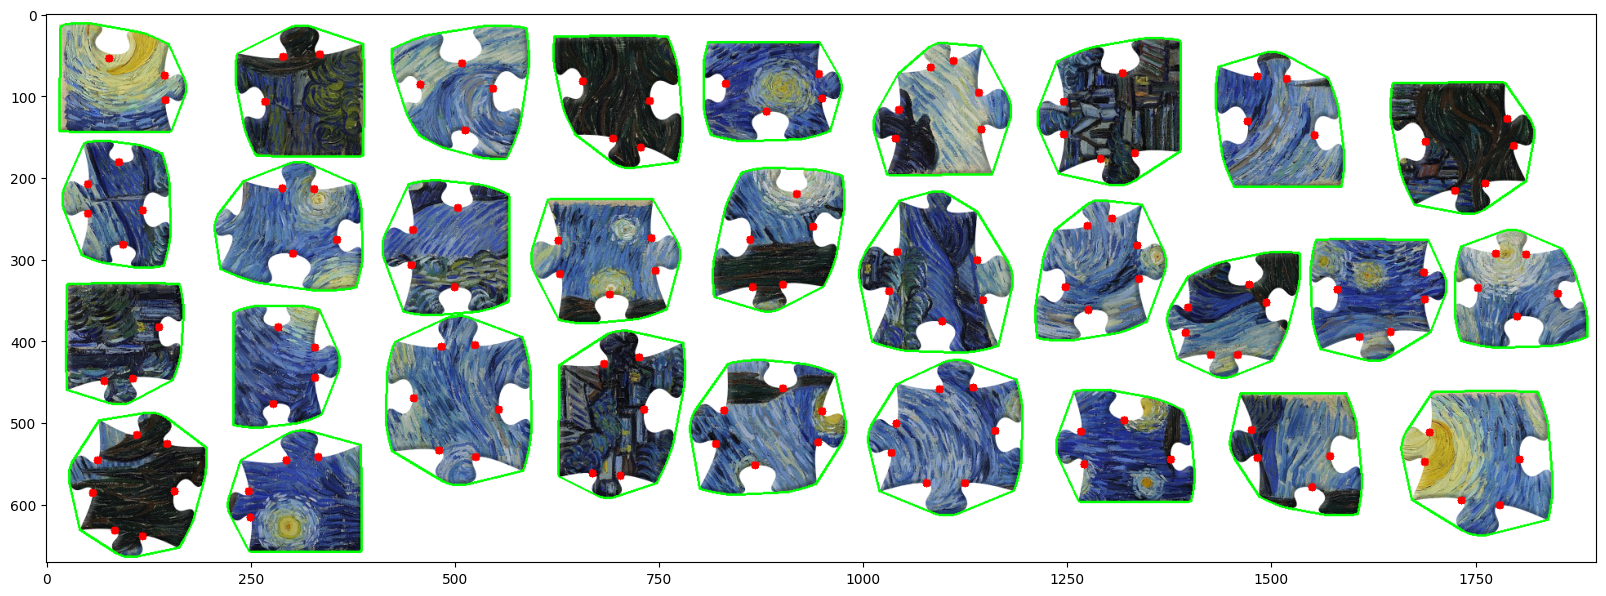

In [135]:
contours_image = img.copy()
lock_points = []
defect_start_end = []
for i in range(len(contours)):
    cnt = contours[i]
    hull = cv2.convexHull(cnt, returnPoints=False)
    defects = cv2.convexityDefects(cnt, hull)
    cv2.drawContours(contours_image, [cnt[hull][:,0,:,:]], -1, color=(0, 255, 0), thickness=2)
    defects_size = defects[:,0,3]/256.
    significant_defects = defects_size>defects_size.max()/2

    local_lock_points = []
    local_defect_start_end = []
    for (s,e,f,d) in defects[significant_defects][:,0]:
        local_defect_start_end.append([s,e])
        local_lock_points.append(f)
        cv2.circle(contours_image,tuple(cnt[f][0]),5,[0,0,255],cv2.FILLED)
    lock_points.append(local_lock_points)
    defect_start_end.append(local_defect_start_end)

plot(contours_image, figsize=(20,10))

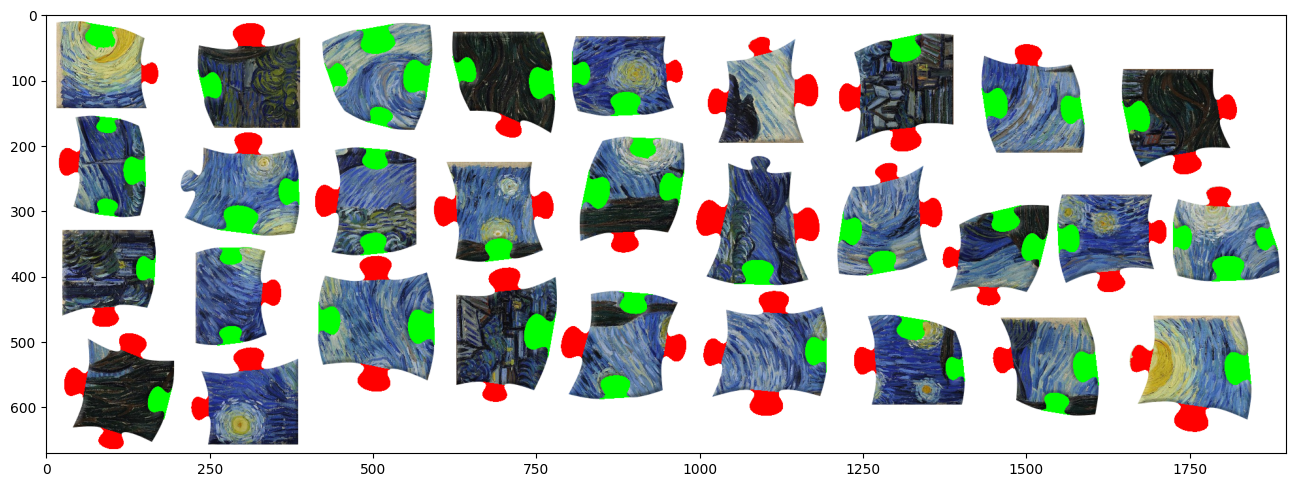

In [167]:
def get_wrapped_contour_section(contour, start_idx, end_idx):
        if start_idx<end_idx:
           return  contour[start_idx:end_idx,:,:]
        return contour[[(idx)%len(contour) for idx in range(start_idx, len(contour)+end_idx)],:,:]

contours_image = img.copy()
head_sections = []
hole_sections = []

for i in range(len(contours)):
    local_lock_points = lock_points[i]
    puzzle_piece_area = cv2.contourArea(contours[i])
    local_head_section = []
    local_hole_section = []
    local_head_mask = np.full(len(local_lock_points), fill_value=False)
    local_hole_section = []

    for j in range(len(local_lock_points)):
        start = local_lock_points[j]
        end = local_lock_points[(j+1)%len(local_lock_points)]
        contour_section = get_wrapped_contour_section(contours[i], start, end)
        area = cv2.contourArea(contour_section)
        perimeter = cv2.arcLength(contour_section, closed=True)
        circularity = area/perimeter**2
        # cv2.circle(contours_image, (contour_section[0,0]), radius=2, color=(0,255,0), thickness=cv2.FILLED)
        # cv2.circle(contours_image, (contour_section[-1,0]), radius=2, color=(0,255,0), thickness=cv2.FILLED)
        if abs(circularity - 0.25/np.pi)<0.03 and area<0.3*puzzle_piece_area:
            cv2.drawContours(contours_image, [contour_section], -1, color=(0, 0, 255), thickness=cv2.FILLED)
            local_head_section.append(contour_section)
            local_head_mask[j] = True
            local_head_mask[(j+1)%len(local_lock_points)] = True
    head_sections.append(local_head_section)
    
    for hole_lock_point, is_head, (defect_start, defect_end) in zip(local_lock_points, local_head_mask, defect_start_end[i]):
        if not is_head:
            contour_section = get_wrapped_contour_section(contours[i], defect_start, defect_end)
            cv2.drawContours(contours_image, [contour_section], -1, color=(0, 255, 0), thickness=cv2.FILLED)
            local_hole_section.append(contour_section)
    hole_sections.append(local_hole_section) 



plot(contours_image, figsize=(16,10))

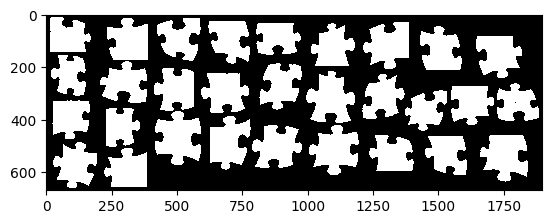

In [171]:
mask = labels_image.copy()
mask[mask>0] = 255

for head_sections

In [170]:
rect = cv2.minAreaRect(cnt)
box = cv2.boxPoints(rect)
box = np.int0(box)
img = cv2.drawContours(img, [box], 0, (0, 0, 255), 2)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)